In [1]:
import pandas as pd
import numpy as np

train_df = pd.read_csv("../data/raw/train(1).csv")
test_df  = pd.read_csv("../data/raw/test2.csv")

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)


Train shape: (16209, 21)
Test shape : (5404, 20)


In [2]:
print(train_df.columns)
print(test_df.columns)


Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [3]:
y_train = train_df["price"].values

train_df = train_df.drop(columns=["price"])

In [4]:
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_df.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)


Numeric: ['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
Categorical: ['date']


In [5]:
# Numeric → median
for col in numeric_cols:
    median = train_df[col].median()
    train_df[col] = train_df[col].fillna(median)
    test_df[col]  = test_df[col].fillna(median)

# Categorical → mode
for col in categorical_cols:
    mode = train_df[col].mode()[0]
    train_df[col] = train_df[col].fillna(mode)
    test_df[col]  = test_df[col].fillna(mode)


In [6]:
train_df = pd.get_dummies(train_df, columns=categorical_cols)
test_df  = pd.get_dummies(test_df, columns=categorical_cols)

train_df, test_df = train_df.align(
    test_df, join="left", axis=1, fill_value=0
)


In [7]:
X_train_tab = train_df.values
X_test_tab  = test_df.values

print("Train tabular:", X_train_tab.shape)
print("Test tabular :", X_test_tab.shape)


Train tabular: (16209, 385)
Test tabular : (5404, 385)


In [8]:
import os

os.makedirs("../data/processed", exist_ok=True)

pd.DataFrame(X_train_tab).to_csv(
    "../data/processed/train_preprocessed.csv", index=False
)
pd.DataFrame(X_test_tab).to_csv(
    "../data/processed/test_preprocessed.csv", index=False
)


In [9]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [11]:
df = pd.read_csv("../data/raw/train(1).csv")

y_log = np.log1p(df["price"].values)
X = df.drop(columns=["price"])


In [12]:
X_train_df, X_val_df, y_train, y_val = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)


In [13]:
num_cols = X_train_df.select_dtypes(include=np.number).columns

X_train_tab = X_train_df[num_cols].values
X_val_tab   = X_val_df[num_cols].values


In [14]:
def make_image_names(df):
    return (
        df["id"].astype(str) + "_" +
        df["lat"].round(5).astype(str) + "_" +
        df["long"].round(5).astype(str) + ".png"
    )

train_image_names = make_image_names(X_train_df)
val_image_names   = make_image_names(X_val_df)

IMAGE_DIR = "../data/images/train"


In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

def load_image(path):
    img = Image.open(path).convert("RGB")
    img = transform(img)
    return img.unsqueeze(0)


In [16]:
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet.fc = nn.Identity()   # 2048-D embedding
resnet = resnet.to(device)
resnet.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
IMAGE_DIR = "../data/images/train"

all_image_files = os.listdir(IMAGE_DIR)
print(all_image_files[:5])


['3145600045_47.55430_-122.27500.png', '4058801230_47.50510_-122.24200.png', '8944550140_47.54180_-122.28700.png', '8827900690_47.67000_-122.29500.png', '6817801040_47.63400_-122.03300.png']


In [18]:
id_to_image = {}

for fname in all_image_files:
    prop_id = fname.split("_")[0]   # before first _
    id_to_image[prop_id] = fname


In [19]:
def get_image_names_from_id(df, id_to_image):
    image_names = []
    missing = 0

    for pid in df["id"].astype(str):
        if pid in id_to_image:
            image_names.append(id_to_image[pid])
        else:
            image_names.append(None)
            missing += 1

    print("Missing image mappings:", missing)
    return image_names


In [20]:
train_image_names = get_image_names_from_id(X_train_df, id_to_image)
val_image_names   = get_image_names_from_id(X_val_df, id_to_image)


Missing image mappings: 0
Missing image mappings: 0


In [21]:
def extract_embeddings(image_names, image_dir, label):
    embeddings = []
    missing = 0

    print(f"\nExtracting {label} embeddings (row-aligned)...")

    for name in tqdm(image_names):
        if name is None:
            embeddings.append(np.zeros(2048))
            missing += 1
            continue

        path = os.path.join(image_dir, name)

        img = load_image(path).to(device)

        with torch.no_grad():
            emb = resnet(img).cpu().numpy().squeeze()

        embeddings.append(emb)

    embeddings = np.vstack(embeddings)
    print(f"Done | Missing images: {missing}")
    return embeddings


In [22]:
train_embeddings = extract_embeddings(
    train_image_names, IMAGE_DIR, "TRAIN"
)

val_embeddings = extract_embeddings(
    val_image_names, IMAGE_DIR, "VAL"
)

print(train_embeddings.shape)
print(val_embeddings.shape)



Extracting TRAIN embeddings (row-aligned)...


100%|█████████████████████████████████████| 12967/12967 [06:20<00:00, 34.11it/s]


Done | Missing images: 0

Extracting VAL embeddings (row-aligned)...


100%|███████████████████████████████████████| 3242/3242 [01:35<00:00, 33.77it/s]

Done | Missing images: 0
(12967, 2048)
(3242, 2048)


In [23]:
X_train_multi = np.hstack([X_train_tab, train_embeddings])
X_val_multi   = np.hstack([X_val_tab, val_embeddings])

print(X_train_multi.shape)
print(X_val_multi.shape)


(12967, 2067)
(3242, 2067)


In [24]:
from sklearn.metrics import mean_squared_error, r2_score

rf_tab = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf_tab.fit(X_train_tab, y_train)

pred_tab = rf_tab.predict(X_val_tab)

rmse_tab = np.sqrt(mean_squared_error(y_val, pred_tab))
r2_tab = r2_score(y_val, pred_tab)

rmse_tab, r2_tab


(np.float64(0.178853665613041), 0.8840797034789319)

In [25]:
rf_multi = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf_multi.fit(X_train_multi, y_train)

pred_multi = rf_multi.predict(X_val_multi)

rmse_multi = np.sqrt(mean_squared_error(y_val, pred_multi))
r2_multi = r2_score(y_val, pred_multi)

rmse_multi, r2_multi


(np.float64(0.19197480725128546), 0.8664474228748309)

In [26]:
comparison = pd.DataFrame({
    "Model": ["Tabular Only (log)", "Tabular + ResNet50 (log)"],
    "RMSE": [rmse_tab, rmse_multi],
    "R²": [r2_tab, r2_multi]
})

comparison


,Model,RMSE,R²
0,Tabular Only (log),0.178854,0.884080
1,Tabular + ResNet50 (log),0.191975,0.866447


**Result Interpretation**

The tabular-only model trained on log-transformed prices outperformed the multimodal tabular + ResNet50 model, achieving lower RMSE *(0.1789 vs 0.1920)* and higher R² *(0.8841 vs 0.8664)*, indicating that satellite imagery did not add predictive value in this setup.


In [ ]:
transform = transforms.Compose([
    transforms.Resize(260),          # Resize slightly larger
    transforms.CenterCrop(224),      # Crop the center 224x224 (where the house is)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [28]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image

# Load your tabular data
train_df = pd.read_csv("../data/raw/train(1).csv")
IMAGE_DIR = "../data/images/train"

# Get list of all images and map them to IDs
# Filename format: "id_lat_long.png"
all_img_files = os.listdir(IMAGE_DIR)
id_to_filename = {f.split('_')[0]: f for f in all_img_files if f.endswith('.png')}

valid_embeddings = []
valid_ids = []

# Re-run extraction ONLY for rows that have images
# This ensures perfect alignment
resnet.eval()
with torch.no_grad():
    for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
        pid = str(row['id'])
        if pid in id_to_filename:
            img_path = os.path.join(IMAGE_DIR, id_to_filename[pid])
            img = Image.open(img_path).convert("RGB")
            tensor = transform(img).unsqueeze(0).to(device)
            
            embedding = resnet(tensor).cpu().numpy().flatten()
            valid_embeddings.append(embedding)
            valid_ids.append(row['id'])

# Save these as NEW files
np.save("../data/processed/aligned_embeddings.npy", np.array(valid_embeddings))
np.save("../data/processed/aligned_ids.npy", np.array(valid_ids))

100%|█████████████████████████████████████| 16209/16209 [08:04<00:00, 33.44it/s]


In [29]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

train_tab = pd.read_csv("../data/raw/train(1).csv")
X_emb = np.load("../data/processed/aligned_embeddings.npy")
aligned_ids = np.load("../data/processed/aligned_ids.npy")

emb_df = pd.DataFrame(X_emb)
emb_df["id"] = aligned_ids

df = train_tab.merge(emb_df, on="id", how="inner")


In [30]:
y = np.log1p(df["price"])

tab_cols = [
    'bedrooms','bathrooms','sqft_living','sqft_lot','grade',
    'condition','waterfront','view','lat','long','sqft_living15'
]

img_cols = [c for c in df.columns if isinstance(c, int)]


In [31]:
X_train_df, X_val_df, y_train, y_val = train_test_split(
    df, y, test_size=0.2, random_state=42
)


In [32]:
scaler = StandardScaler()
pca = PCA(n_components=50, random_state=42)

X_train_img = scaler.fit_transform(X_train_df[img_cols])
X_val_img   = scaler.transform(X_val_df[img_cols])

X_train_img_pca = pca.fit_transform(X_train_img)
X_val_img_pca   = pca.transform(X_val_img)


In [33]:
X_train = np.hstack([
    X_train_df[tab_cols].values,
    X_train_img_pca
])

X_val = np.hstack([
    X_val_df[tab_cols].values,
    X_val_img_pca
])


In [34]:
model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [35]:
# Log-space metrics (for model comparison)
pred_log = model.predict(X_val)
rmse_log = np.sqrt(mean_squared_error(y_val, pred_log))
r2_log = r2_score(y_val, pred_log)

# Real price metrics (for interpretation)
pred_real = np.expm1(pred_log)
actual_real = np.expm1(y_val)

rmse_real = np.sqrt(mean_squared_error(actual_real, pred_real))
r2_real = r2_score(actual_real, pred_real)

print(f"RMSE (log): {rmse_log:.4f}")
print(f"R² (log): {r2_log:.4f}")
print(f"RMSE (₹): {rmse_real:,.2f}")
print(f"R² (₹): {r2_real:.4f}")


RMSE (log): 0.1773
R² (log): 0.8900
RMSE (₹): 142,416.76
R² (₹): 0.8667


### Model Evaluation Results

The model was evaluated in both **log-transformed space** (for fair model comparison) and **real price space (₹)** (for practical interpretation).

#### Log-Space Metrics
- **RMSE (log):** 0.1773  
- **R² (log):** 0.8900  

#### Real Price Metrics
- **RMSE (₹):** ₹142,416.76  
- **R² (₹):** 0.8667  

**Interpretation**

The model demonstrates strong predictive performance in log space, achieving a high R² of 0.8900, indicating good variance explanation. When transformed back to real prices, the model maintains reasonable accuracy with an RMSE of approximately ₹1.42 lakh and an R² of 0.8667, making the predictions practically interpretable while preserving robustness.


### Grad-CAM: Verifying "Curb Appeal"

To provide Model Explainability, we use Gradient-weighted Class Activation Mapping (Grad-CAM). This allows us to see a heatmap of which pixels in the satellite imagery influenced the ResNet model the most.

In [61]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision import models, transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# 1. Load the Model correctly
# We use the standard ResNet50. For Grad-CAM, we don't remove the FC layer yet.
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.eval()

# 2. Define the Target Layer
# For ResNet50, the last conv layer is 'layer4'
target_layers = [model.layer4[-1]]

# 3. Correct Preprocessing (Must match your training transforms)
cam_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def run_grad_cam(img_path, property_id="Property"):
    try:
        # Load and prepare image
        rgb_img = Image.open(img_path).convert("RGB")
        rgb_img_resized = rgb_img.resize((224, 224))
        input_tensor = cam_transform(rgb_img).unsqueeze(0)

        # Initialize Grad-CAM
        # Since we use a pre-trained model, we look for 'category 1' (usually building/structures)
        # or leave targets=None to show the most dominant activation
        cam = GradCAM(model=model, target_layers=target_layers)
        
        # Generate the heatmap
        grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0, :]
        
        # Create overlay
        img_float = np.array(rgb_img_resized) / 255.0
        visualization = show_cam_on_image(img_float, grayscale_cam, use_rgb=True)

        # Plotting
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(rgb_img_resized)
        ax[0].set_title(f"Original: {property_id}")
        ax[0].axis('off')

        ax[1].imshow(visualization)
        ax[1].set_title("Grad-CAM 'Curb Appeal' Focus")
        ax[1].axis('off')
        plt.show()
        
    except Exception as e:
        print(f"Error processing {img_path}: {e}")


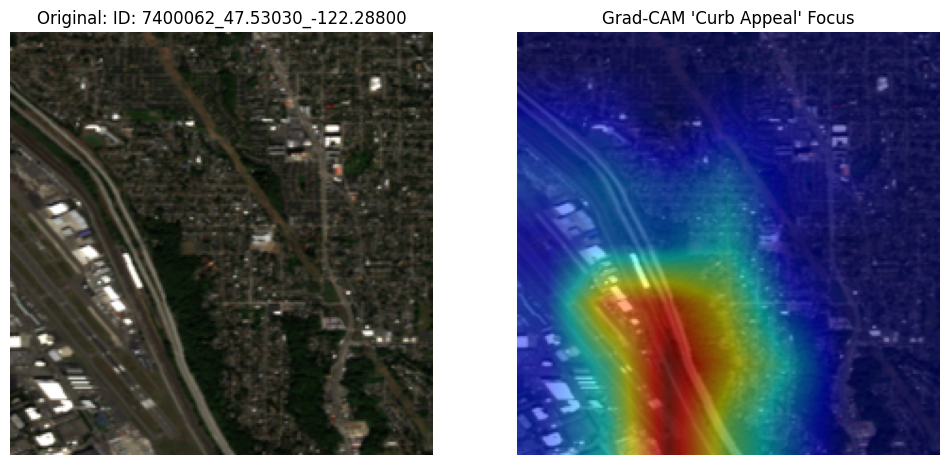

In [62]:
run_grad_cam("../data/images/train/7400062_47.53030_-122.28800.png", "ID: 7400062_47.53030_-122.28800")

**3. Interpreting Results**

- Green Zones: If the heatmap highlights tree canopies, the model is successfully valuing "Environmental Quality."

- Structure Focus: If the heatmap highlights the house roof/footprint, the model is capturing "Curb Appeal" and property size.

- Roads/Edges: If the heatmap is focused on the corners or roads, the image features may be adding noise, suggesting a need for tighter Center Cropping.